In [ ]:
import numpy as np
import pandas as pd
import pickle
import re

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score
from sklearn.metrics import RocCurveDisplay, roc_curve, auc

from sklearn.tree import plot_tree

from sklearn.ensemble import RandomForestClassifier
from IPython.display import display

import matplotlib.pyplot as plt

# Model Interpretability
Our best model is Random Forest Classifier with engineered features. Implicitly Random forest is interpretable using gini score and information gain score. At each node we can calculate probability using number of datapoints.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
_CWD = '/content/drive/MyDrive' #for google drive

In [ ]:
dataset_FE = pd.read_pickle(_CWD+'/FE_dataset.sav')
X_train, X_test, y_train, y_test = dataset_FE

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(19696, 2503)
(8442, 2503)
(19696,)
(8442,)


In [ ]:
# Loading the best pre-trained model
with open(_CWD+'/final_RFC_FE_model.model', 'rb') as file:
  RFC_FE_model = pickle.load(file)

Let's try to visualize the 20th estimator from random trees.

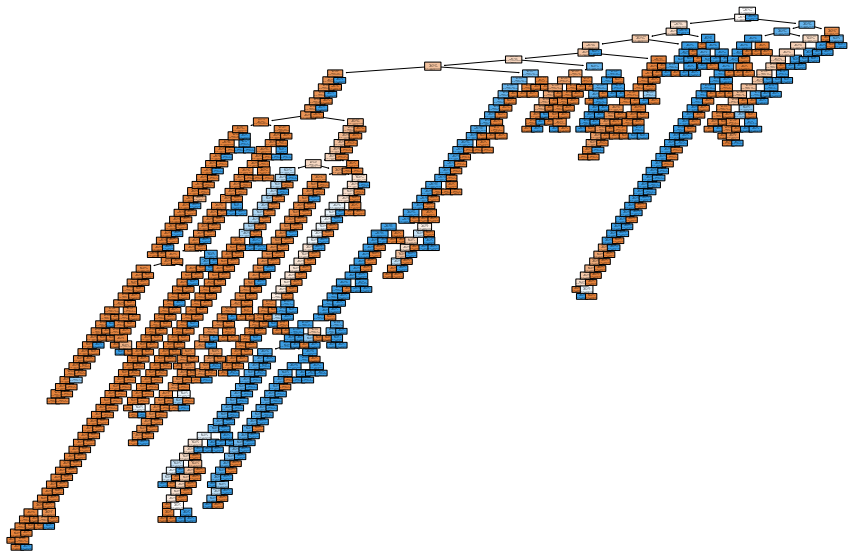

In [ ]:
fig = plt.figure(figsize=(15, 10))
plot_tree(RFC_FE_model.estimators_[20], 
          feature_names=X_train.columns,
          class_names=['1','0'], 
          filled=True, impurity=True, 
          rounded=True);

Our tree is really deep and not very useful to understand what is happening. This happened because of very high number of dimension data.  
Let's try **LIME** to understand the feature importance and make sure the model is giving answer which are explainable.

# Model pipeline  
We will create pipeline to predict the unseen data in future. To do that we need to first clean the data, transform the data and then predict the label using RFC_FE model.  
For this task we will create utility functions in the python file and import directly here. This python file will be used in the deployment as well.

In [ ]:


_CWD = '/content/drive/MyDrive' #for google drive
with open(_CWD+'/final_RFC_FE_model.model', 'rb') as file:
  RFC_FE_model = pickle.load(file)
with open(_CWD+'/tfidf_vec.sav', 'rb') as file:
  TFIDF_vectorizer = pickle.load(file)

def clean_query(input_string):
  # print(type(input_string), input_string)
  cleaned = re.sub('[^a-zA-Z0-9\s]',' ',input_string)
  cleaned = re.sub('\s{2,}',' ',cleaned)
  return cleaned.lower().strip()

def predict_class(X_query):
  cleaned_query = clean_query(X_query)
  no_of_special_chars = len(re.findall('[^a-zA-Z0-9\s]',X_query))
  query_length = len(X_query.split())
  no_of_num_eq_num = len(re.findall(r'\d\s*=\s*\d',X_query))
  X_q = TFIDF_vectorizer.transform([cleaned_query])
  X_q_tfidf_FE = pd.DataFrame(data=X_q.toarray(),columns=TFIDF_vectorizer.get_feature_names_out())
  X_q_tfidf_FE['num_sc'] = no_of_special_chars
  X_q_tfidf_FE['q_len'] = query_length
  X_q_tfidf_FE['num_eq_num'] = no_of_num_eq_num
  proba = RFC_FE_model.predict_proba(X_q_tfidf_FE)
  pred_class = RFC_FE_model.predict(X_q_tfidf_FE)
  return proba[0]

def predict_proba(X_q_obj):
  if isinstance(X_q_obj,list):
    proba = []
    for x in X_q_obj:
      proba.append(predict_class(x))
    
    return np.array(proba)
  if isinstance(X_q_obj, str):
    return predict_class(X_q_obj)

# Model interpretation (LIME)

In [ ]:
# Let's install lime if not available
!pip install lime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 275 kB 7.7 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=0c08fafcad9f7c326c07aa41743184279b5891e04bcbe0f8b83b55c3c059d6d0
  Stored in directory: /root/.cache/pip/wheels/ca/cb/e5/ac701e12d365a08917bf4c6171c0961bc880a8181359c66aa7
Successfully built lime


In [ ]:
# ref - https://marcotcr.github.io/lime/tutorials/Lime%20-%20basic%20usage%2C%20two%20class%20case.html
import lime
from lime import lime_text
from lime.lime_text import LimeTextExplainer
explainer = LimeTextExplainer(class_names=y_train.unique(),)

Let's get raw_dataset so that we can use random query to test our LIME model.

In [ ]:
raw_dataset = pd.read_csv("/content/drive/MyDrive/Modified_SQL_Dataset.csv")

In [ ]:
# utility function to generate LIME explanation given index
def lime_explain(index):
  X_q = raw_dataset.iloc[index].Query
  y_true = raw_dataset.iloc[index].Label
  exp = explainer.explain_instance(X_q, predict_proba)
  print('True Class: ', y_true)
  y_pred_global = exp.predict_proba
  print('P(0): ',y_pred_global[0],'\nP(1): ',y_pred_global[1])
  exp.show_in_notebook(text=True)
  exp.save_to_file(_CWD+'/oi'+str(index)+'.html')

In [ ]:
idx = 22
X_q = raw_dataset.iloc[idx].Query
y_true = raw_dataset.iloc[idx].Label
exp = explainer.explain_instance(X_q, predict_proba)
print('True Class: ', y_true)

True Class:  1


Let's take examples of some **class 1**

In [ ]:
for x in [6,11,15,18,22,47]:
  lime_explain(x)

Output hidden; open in https://colab.research.google.com to view.

Let's take examples of some **class 0**

In [ ]:
for x in [22377,30918,19377,20380,27381]:
  lime_explain(x)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
y_pred = RFC_FE_model.predict_proba(X_test)

# Advanced Modeling
Our model is doing great work. As seen on previous phase, there is no room for improvement as error points are not trivial and mostly one word.  
Let's try deep learning models and RNN models to compare the results with machine learning model.

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
import tensorflow as tf
from tensorflow.keras.layers import LSTM
import numpy as np
from sklearn.metrics import classification_report

In [ ]:
_CWD = '/content/drive/MyDrive' #for google drive

dataset_FE = pd.read_pickle(_CWD+'/FE_dataset.sav')
X_train, X_test, y_train, y_test = dataset_FE

## Deep Learning model
Let's first try multi level perceptron model on our Feature Engineer dataset with **2503** features.

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(19696, 2503)
(8442, 2503)
(19696,)
(8442,)


In [ ]:
# define the model
model = Sequential()
model.add(Dense(250, input_shape=(2503,)))
model.add(Dense(125))
model.add(Dense(60))
model.add(Dense(25))
model.add(Dense(1))

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_test, y_test),
                    validation_steps=30)

Epoch 1/10
616/616 [==============================] - 8s 11ms/step - loss: 0.1532 - accuracy: 0.9510 - val_loss: 0.0323 - val_accuracy: 0.9914
Epoch 2/10
616/616 [==============================] - 6s 10ms/step - loss: 0.0297 - accuracy: 0.9926 - val_loss: 0.0253 - val_accuracy: 0.9934
Epoch 3/10
616/616 [==============================] - 6s 10ms/step - loss: 0.0244 - accuracy: 0.9944 - val_loss: 0.0208 - val_accuracy: 0.9955
Epoch 4/10
616/616 [==============================] - 6s 10ms/step - loss: 0.0222 - accuracy: 0.9954 - val_loss: 0.0210 - val_accuracy: 0.9948
Epoch 5/10
616/616 [==============================] - 6s 10ms/step - loss: 0.0206 - accuracy: 0.9951 - val_loss: 0.0196 - val_accuracy: 0.9960
Epoch 6/10
616/616 [==============================] - 6s 10ms/step - loss: 0.0187 - accuracy: 0.9960 - val_loss: 0.0197 - val_accuracy: 0.9960
Epoch 7/10
616/616 [==============================] - 6s 10ms/step - loss: 0.0179 - accuracy: 0.9963 - val_loss: 0.0205 - val_accuracy: 0.9961

Our model has achieved really good accuracy on training and validation dataset.  
Let's plot the graph accuracy and loss vs epochs.

In [ ]:
# utility function to plot the graph given history object
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

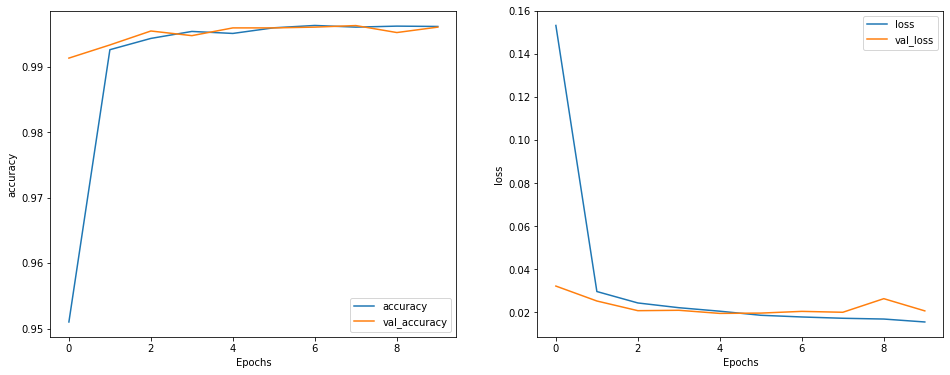

In [ ]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

Evaluating Keras model with FE...
264/264 [==============================] - 1s 5ms/step - loss: 0.0207 - accuracy: 0.9961
Training Accuracy =  99.6954  %
Testing Accuracy =  99.6091  %
F1 Score for Keras model with FE: 99.3621 %
roc_auc =  99.3974


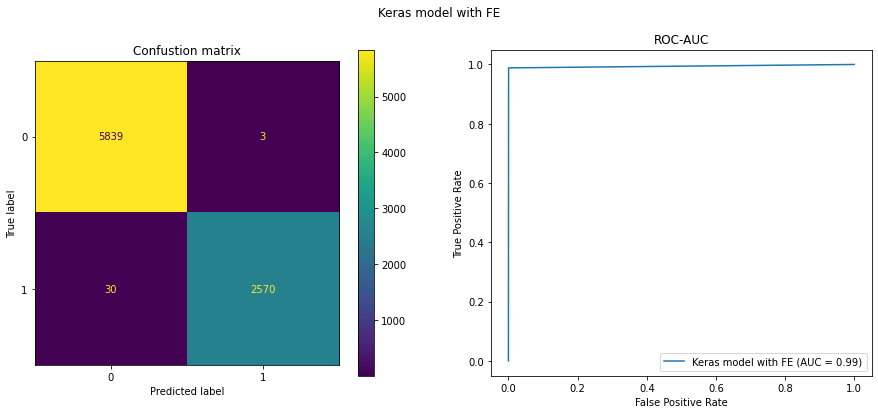

In [ ]:
train_data=X_train
train_label=y_train
model_name='Keras model with FE'

print(f'Evaluating {model_name}...')
train_acc_score = model.evaluate(train_data, train_label);
test_acc_score = model.evaluate(X_test, y_test);

print('Training Accuracy = ',round(train_acc_score[1]*100, 4), ' %')
print('Testing Accuracy = ',round(test_acc_score[1]*100, 4), ' %')

y_predictions = (model.predict(X_test) > 0.5).astype("int32")
print(f"F1 Score for {model_name}: {round(f1_score(y_test, y_predictions)*100,4)} %")

confusion_mat = ConfusionMatrixDisplay(confusion_matrix(y_test, y_predictions))

fpr, tpr, thresholds = roc_curve(y_test, y_predictions)
roc_auc = auc(fpr, tpr)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name=model_name)
print("roc_auc = ", round(roc_auc*100,4))

figure, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(15,6))
confusion_mat.plot(ax=ax1)
ax1.set_title('Confustion matrix')
roc_display.plot(ax=ax2)
ax2.set_title('ROC-AUC')
figure.suptitle(model_name);

In [ ]:
print(classification_report(y_test, y_predictions))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      5842
           1       1.00      0.99      0.99      2600

    accuracy                           1.00      8442
   macro avg       1.00      0.99      1.00      8442
weighted avg       1.00      1.00      1.00      8442



# RNN
Let's try RNN to solve this problem. For RNN we can not use TFIDF vectors.  
We will use the raw dataset text(queries) for RNN.

## Single RNN layer

In [ ]:
dataset_all_cleaned = pd.read_pickle(_CWD+'/dataset_all_cleaned.df')

In [ ]:
X_rnn = dataset_all_cleaned['Query']
y_rnn = dataset_all_cleaned['Label']

In [ ]:
X_train_rnn, X_test_rnn, y_train_rnn, y_test_rnn = train_test_split(X_rnn, y_rnn, test_size=0.30, random_state=42)

In [ ]:
train_tf_dataset = tf.data.Dataset.from_tensor_slices((X_train_rnn, y_train_rnn))
test_tf_dataset = tf.data.Dataset.from_tensor_slices((X_test_rnn, y_test_rnn))

In [ ]:
for example, label in train_tf_dataset.take(1):
  print('query: ', example.numpy())
  print('label: ', label.numpy())

query:  b'select top 3 from carefully'
label:  0


In [ ]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_tf_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_tf_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b'jardines 110' b'0orru6t5' b'46160431y']

labels:  [0 0 0]


Below code creates the encodings from the train dataset text.

In [ ]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [ ]:
# Print 20 tokens from vocabulary
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'select', 'from', '1', 'where', 'and', 'chr', 'as',
       'char', '113', 'or', 'null', 'all', 'union', 'count', '0', '3',
       'by', 'end'], dtype='<U19')

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        mask_zero=True),                                      # Embedding layer to encode text
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),  # RNN bidirectional layer
    tf.keras.layers.Dense(64, activation='relu'),             # Dense layer with 64 neurons
    tf.keras.layers.Dense(1)                                  # Output layer
])

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
308/308 [==============================] - 41s 108ms/step - loss: 0.4318 - accuracy: 0.8232 - val_loss: 0.1381 - val_accuracy: 0.9849
Epoch 2/10
308/308 [==============================] - 29s 93ms/step - loss: 0.0856 - accuracy: 0.9852 - val_loss: 0.0572 - val_accuracy: 0.9906
Epoch 3/10
308/308 [==============================] - 29s 93ms/step - loss: 0.0463 - accuracy: 0.9927 - val_loss: 0.0404 - val_accuracy: 0.9953
Epoch 4/10
308/308 [==============================] - 28s 92ms/step - loss: 0.0312 - accuracy: 0.9952 - val_loss: 0.0278 - val_accuracy: 0.9953
Epoch 5/10
308/308 [==============================] - 29s 93ms/step - loss: 0.0249 - accuracy: 0.9953 - val_loss: 0.0189 - val_accuracy: 0.9958
Epoch 6/10
308/308 [==============================] - 28s 92ms/step - loss: 0.0213 - accuracy: 0.9957 - val_loss: 0.0160 - val_accuracy: 0.9958
Epoch 7/10
308/308 [==============================] - 29s 93ms/step - loss: 0.0196 - accuracy: 0.9958 - val_loss: 0.0155 - val_accuracy

RNN layer is also giving really good accuracy above 99.5% for both training and validation data.

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

132/132 [==============================] - 3s 24ms/step - loss: 0.0178 - accuracy: 0.9963
Test Loss: 0.017844460904598236
Test Accuracy: 0.9963278770446777


(0.0, 0.4526716159656644)

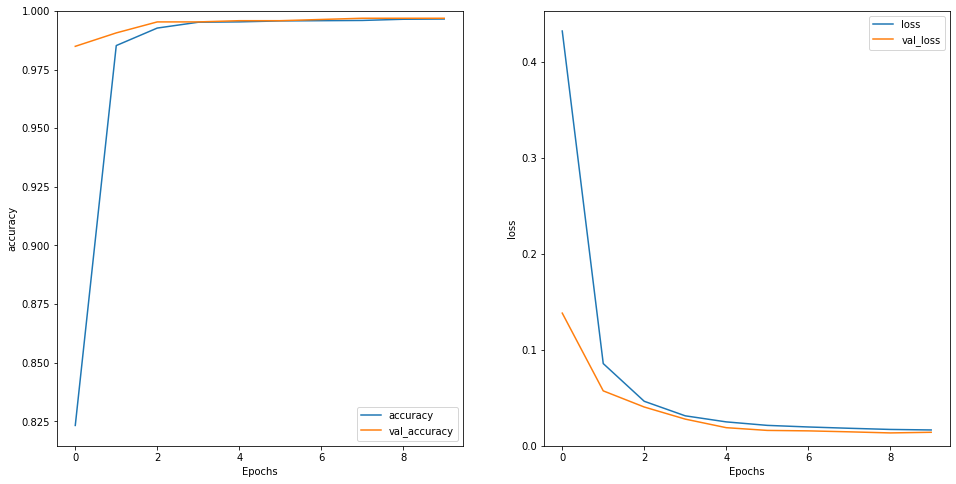

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

Evaluating RNN model...
132/132 [==============================] - 3s 24ms/step - loss: 0.0178 - accuracy: 0.9963
Training Accuracy =  99.7004  %
Testing Accuracy =  99.6328  %
F1 Score for RNN model: 99.4017 %
roc_auc =  99.4679


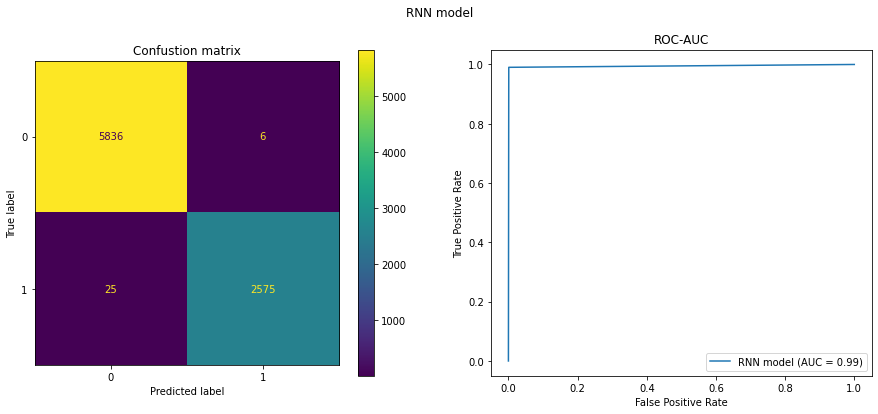

In [ ]:
model_name='RNN model'

print(f'Evaluating {model_name}...')
train_acc_score = model.evaluate(train_dataset);
test_acc_score = model.evaluate(test_dataset);

print('Training Accuracy = ',round(train_acc_score[1]*100, 4), ' %')
print('Testing Accuracy = ',round(test_acc_score[1]*100, 4), ' %')

y_predictions = (model.predict(X_test_rnn) > 0.5).astype("int32")
print(f"F1 Score for {model_name}: {round(f1_score(y_test_rnn, y_predictions)*100,4)} %")

confusion_mat = ConfusionMatrixDisplay(confusion_matrix(y_test_rnn, y_predictions))

fpr, tpr, thresholds = roc_curve(y_test_rnn, y_predictions)
roc_auc = auc(fpr, tpr)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name=model_name)
print("roc_auc = ", round(roc_auc*100,4))

figure, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(15,6))
confusion_mat.plot(ax=ax1)
ax1.set_title('Confustion matrix')
roc_display.plot(ax=ax2)
ax2.set_title('ROC-AUC')
figure.suptitle(model_name);

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),     # Embedding layer
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),  # LSTM layer 1
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),                          # LSTM layer 2
    tf.keras.layers.Dense(64, activation='relu'),                                     # Dense layer
    tf.keras.layers.Dropout(0.5),                                                     # Dropout layer
    tf.keras.layers.Dense(1)                                                          # Output layer
])

model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
308/308 [==============================] - 72s 179ms/step - loss: 0.4257 - accuracy: 0.8392 - val_loss: 0.1442 - val_accuracy: 0.9870
Epoch 2/10
308/308 [==============================] - 49s 159ms/step - loss: 0.1104 - accuracy: 0.9872 - val_loss: 0.0804 - val_accuracy: 0.9958
Epoch 3/10
308/308 [==============================] - 49s 158ms/step - loss: 0.0685 - accuracy: 0.9922 - val_loss: 0.0434 - val_accuracy: 0.9964
Epoch 4/10
308/308 [==============================] - 48s 157ms/step - loss: 0.0428 - accuracy: 0.9947 - val_loss: 0.0279 - val_accuracy: 0.9964
Epoch 5/10
308/308 [==============================] - 49s 160ms/step - loss: 0.0334 - accuracy: 0.9949 - val_loss: 0.0206 - val_accuracy: 0.9964
Epoch 6/10
308/308 [==============================] - 50s 162ms/step - loss: 0.0275 - accuracy: 0.9951 - val_loss: 0.0152 - val_accuracy: 0.9969
Epoch 7/10
308/308 [==============================] - 49s 159ms/step - loss: 0.0246 - accuracy: 0.9953 - val_loss: 0.0138 - val_ac

Multilevel RNN model is also giving really good accuracy above 99.5% for train and validation dataset.

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

132/132 [==============================] - 6s 47ms/step - loss: 0.0142 - accuracy: 0.9967
Test Loss: 0.014172585681080818
Test Accuracy: 0.9966832399368286


(0.0, 0.4462662965990603)

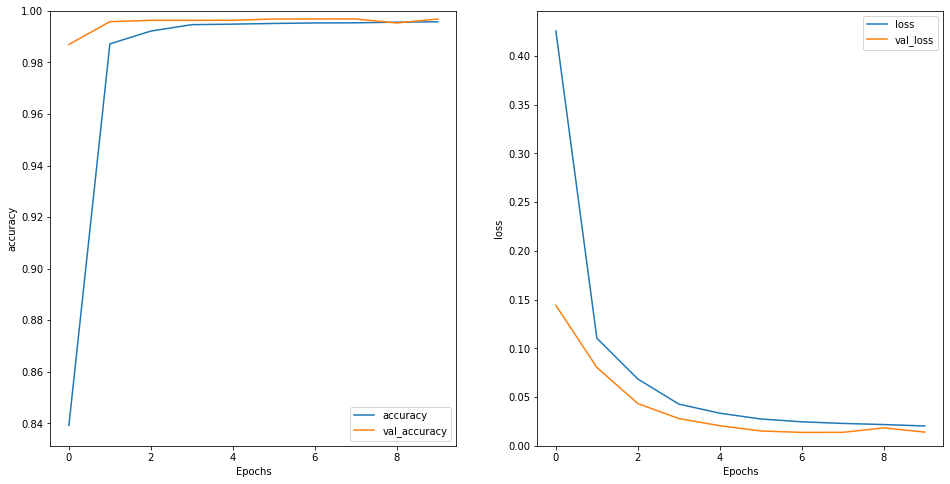

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

Evaluating RNN model...
132/132 [==============================] - 6s 47ms/step - loss: 0.0142 - accuracy: 0.9967
Training Accuracy =  99.6141  %
Testing Accuracy =  99.6683  %
F1 Score for RNN model: 99.4588 %
roc_auc =  99.4722


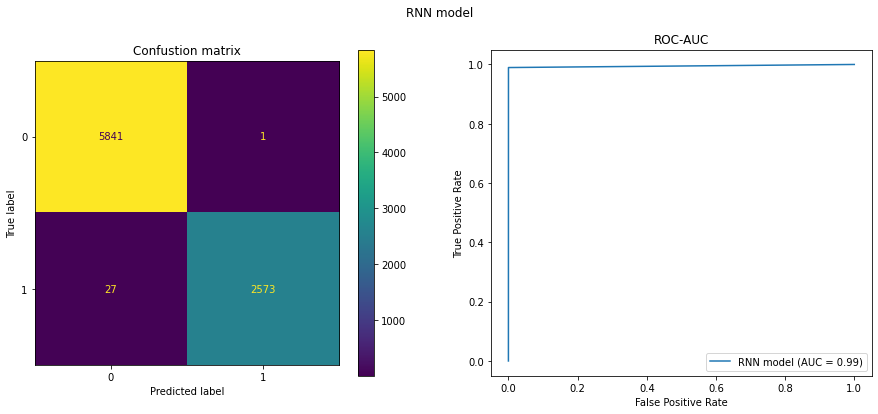

In [ ]:
model_name='RNN model'

print(f'Evaluating {model_name}...')
train_acc_score = model.evaluate(train_dataset);
test_acc_score = model.evaluate(test_dataset);

print('Training Accuracy = ',round(train_acc_score[1]*100, 4), ' %')
print('Testing Accuracy = ',round(test_acc_score[1]*100, 4), ' %')

y_predictions = (model.predict(X_test_rnn) > 0.5).astype("int32")
print(f"F1 Score for {model_name}: {round(f1_score(y_test_rnn, y_predictions)*100,4)} %")

confusion_mat = ConfusionMatrixDisplay(confusion_matrix(y_test_rnn, y_predictions))

fpr, tpr, thresholds = roc_curve(y_test_rnn, y_predictions)
roc_auc = auc(fpr, tpr)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name=model_name)
print("roc_auc = ", round(roc_auc*100,4))

figure, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(15,6))
confusion_mat.plot(ax=ax1)
ax1.set_title('Confustion matrix')
roc_display.plot(ax=ax2)
ax2.set_title('ROC-AUC')
figure.suptitle(model_name);